In [1]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

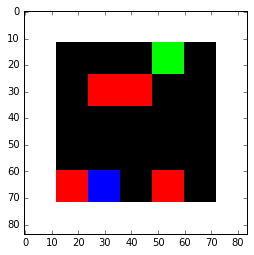

In [12]:
from gridworld_v02 import gameEnv
env = gameEnv(partial=False, size=5)

In [3]:
class Qnetwork():
    def __init__(self, h_size, name = "main"): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutinoal layers.
        self.net_name = name
        self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        self.conv1 = slim.conv2d(inputs=self.imageIn,
                                 num_outputs=32,
                                 kernel_size=[8,8],
                                 stride=[4,4],
                                 padding='VALID', 
                                 biases_initializer = None)
        
        self.conv2 = slim.conv2d(inputs=self.conv1,
                                 num_outputs=64,
                                 kernel_size=[4,4],
                                 stride=[2,2],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv3 = slim.conv2d(inputs=self.conv2,
                                 num_outputs=64,
                                 kernel_size=[3,3],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv4 = slim.conv2d(inputs=self.conv3,
                                 num_outputs=h_size,
                                 kernel_size=[7,7],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        #We take the output from the final convolutional layer and split it into separated terms: advantage & value
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        self.AW = tf.Variable(xavier_init([h_size//2, env.actions]))
        self.VM = tf.Variable(xavier_init([h_size//2, 1]))
        
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VM)
        
        #Then combine to obtain the final Q-value //why substract mean from Advantage?
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)    
    

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [5]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [6]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [7]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [8]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 10 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 10000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 3*10000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 10000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 50

load_model = False #Wheter to load a saved model
path = "./dqn_logs_sh4" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [9]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
def replay_train(trainBatch):
    #print("traingBatch shape" + str(trainBatch.shape))

    #Perform the Double-DQN update to the target Q-values
    Q1 = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
    #print("Q1" + str(np.vstack(trainBatch[:,3])))

    Q2 = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
    end_multiplier = -(trainBatch[:,4]-1)
    #print("Q2" + str(Q2))

    doubleQ = Q2[range(batch_size), Q1]
    targetQ = trainBatch[:,2] + (y * doubleQ * end_multiplier)

    #Update the network with our target values
    return sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.targetQ:targetQ,
                          mainQN.actions:trainBatch[:,1]})


In [11]:
with tf.Session() as sess:
    sess.run(init)
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    #Set the target network to be equal to primary network
    #updateTarget(targetOps, sess) 
    copy_ops = get_copy_var_ops(dest_scope_name="target", src_scope_name="main")
    sess.run(copy_ops)
    
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get the first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        step_count = 0
        
        #Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j+=1
            step_count += 1
            
            #Choose an action by greedily picking (with e chance of chosing randomly) from the Q-net
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else: 
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
            #plt.imshow(s1, interpolation = "nearest")
            s1 = processState(s1)#// flatten the return frame
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to the episode buffer
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size)
                    loss = replay_train(trainBatch)
                    sess.run(copy_ops)
                    
                    
            rAll += r
            s = s1
                
            if d == True:
                break
                        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
            
        #Periodically save the model
        if i % 1000 == 0:
            saver.save(sess, path + '/model-' + str(i) + '.cptk')
            print("Model Saved")
        if len(rList) % 10 == 0:
            accumR = np.mean(rList[-10:])
            log = "Tot Steps: " + str(total_steps) +"\t"+ str(accumR) +"\t"+ str(e) 
            print(log)
            #f.write(log)
            
       # if total_steps > pre_train_steps and i % 10 == 1:
           
            #Set the target network to be equal to the primary network
         #   updateTarget(targetOps, sess)
                
    saver.save(sess, path + '/model-' + str(i) + '.cptk')#// save final model?

final_log = "Percent of sucessful episodes: " + str(sum(rList)/num_episodes) + "%"
print(final_log)
#f.write(final_log)
#f.close()


=====Episode 0start =====
Model Saved
Tot Steps: 63	-0.8	1
Tot Steps: 153	-0.6	1
Tot Steps: 202	-0.8	1
Tot Steps: 318	-0.8	1
Tot Steps: 412	0.0	1
Tot Steps: 510	-0.4	1
Tot Steps: 680	-0.8	1
Tot Steps: 750	-0.2	1
Tot Steps: 855	-0.8	1
Tot Steps: 965	-0.2	1

=====Episode 100start =====
Tot Steps: 1044	-0.6	1
Tot Steps: 1149	-0.4	1
Tot Steps: 1225	-0.4	1
Tot Steps: 1363	-0.6	1
Tot Steps: 1458	-0.4	1
Tot Steps: 1531	0.0	1
Tot Steps: 1618	0.0	1
Tot Steps: 1666	-0.8	1
Tot Steps: 1744	-0.6	1
Tot Steps: 1821	-0.8	1

=====Episode 200start =====
Tot Steps: 1928	-0.4	1
Tot Steps: 2023	-0.4	1
Tot Steps: 2115	-0.4	1
Tot Steps: 2178	-0.8	1
Tot Steps: 2238	-0.6	1
Tot Steps: 2312	-0.4	1
Tot Steps: 2438	-0.6	1
Tot Steps: 2492	-0.8	1
Tot Steps: 2568	-0.6	1
Tot Steps: 2731	-0.7	1

=====Episode 300start =====
Tot Steps: 2858	-0.2	1
Tot Steps: 2930	-0.8	1
Tot Steps: 3040	-0.8	1
Tot Steps: 3091	-1.0	1
Tot Steps: 3232	-0.8	1
Tot Steps: 3343	-0.4	1
Tot Steps: 3392	-0.4	1
Tot Steps: 3502	-1.0	1
Tot Steps: 364

Tot Steps: 34183	-0.3	0.09999999999985551
Tot Steps: 34524	-0.3	0.09999999999985551
Tot Steps: 34934	-0.1	0.09999999999985551
Tot Steps: 35245	-0.3	0.09999999999985551
Tot Steps: 35582	-0.4	0.09999999999985551
Tot Steps: 35834	-0.4	0.09999999999985551
Tot Steps: 36004	-0.4	0.09999999999985551
Tot Steps: 36227	-0.1	0.09999999999985551
Tot Steps: 36459	-0.2	0.09999999999985551
Tot Steps: 36833	-0.3	0.09999999999985551

=====Episode 2400start =====
Tot Steps: 37198	-0.3	0.09999999999985551
Tot Steps: 37483	-0.2	0.09999999999985551
Tot Steps: 37833	-0.2	0.09999999999985551
Tot Steps: 38191	0.1	0.09999999999985551
Tot Steps: 38594	-0.1	0.09999999999985551
Tot Steps: 38861	-0.2	0.09999999999985551
Tot Steps: 39077	-0.4	0.09999999999985551
Tot Steps: 39407	-0.3	0.09999999999985551
Tot Steps: 39740	-0.3	0.09999999999985551
Tot Steps: 40026	-0.1	0.09999999999985551

=====Episode 2500start =====
Tot Steps: 40292	-0.5	0.09999999999985551
Tot Steps: 40680	-0.2	0.09999999999985551
Tot Steps: 41061	

Tot Steps: 93248	0.0	0.09999999999985551
Tot Steps: 93403	-0.7	0.09999999999985551
Tot Steps: 93729	-0.2	0.09999999999985551
Tot Steps: 93975	0.0	0.09999999999985551
Tot Steps: 94287	-0.7	0.09999999999985551
Tot Steps: 94609	-0.4	0.09999999999985551
Tot Steps: 94818	-0.6	0.09999999999985551

=====Episode 4200start =====
Tot Steps: 95139	-0.5	0.09999999999985551
Tot Steps: 95497	-0.2	0.09999999999985551
Tot Steps: 95810	-0.3	0.09999999999985551
Tot Steps: 96120	0.1	0.09999999999985551
Tot Steps: 96489	-0.3	0.09999999999985551
Tot Steps: 96846	-0.1	0.09999999999985551
Tot Steps: 97096	0.0	0.09999999999985551
Tot Steps: 97429	0.0	0.09999999999985551
Tot Steps: 97716	-0.1	0.09999999999985551
Tot Steps: 98123	-0.2	0.09999999999985551

=====Episode 4300start =====
Tot Steps: 98487	-0.3	0.09999999999985551
Tot Steps: 98827	-0.4	0.09999999999985551
Tot Steps: 99261	-0.3	0.09999999999985551
Tot Steps: 99684	0.0	0.09999999999985551
Tot Steps: 99909	-0.6	0.09999999999985551
Tot Steps: 100284	-0.1

Tot Steps: 149635	-0.2	0.09999999999985551
Tot Steps: 149871	-0.3	0.09999999999985551
Tot Steps: 150251	-0.2	0.09999999999985551
Tot Steps: 150635	-0.4	0.09999999999985551
Tot Steps: 151073	-0.2	0.09999999999985551
Tot Steps: 151412	-0.4	0.09999999999985551
Tot Steps: 151751	-0.1	0.09999999999985551
Tot Steps: 152042	-0.5	0.09999999999985551

=====Episode 6000start =====
Model Saved
Tot Steps: 152443	0.0	0.09999999999985551
Tot Steps: 152762	-0.1	0.09999999999985551
Tot Steps: 153127	-0.2	0.09999999999985551
Tot Steps: 153530	-0.2	0.09999999999985551
Tot Steps: 153778	-0.6	0.09999999999985551
Tot Steps: 154028	-0.5	0.09999999999985551
Tot Steps: 154262	-0.1	0.09999999999985551
Tot Steps: 154484	-0.5	0.09999999999985551
Tot Steps: 154938	-0.1	0.09999999999985551
Tot Steps: 155087	-0.9	0.09999999999985551

=====Episode 6100start =====
Tot Steps: 155441	-0.2	0.09999999999985551
Tot Steps: 155738	-0.5	0.09999999999985551
Tot Steps: 156190	0.1	0.09999999999985551
Tot Steps: 156690	0.0	0.099

Tot Steps: 204987	-0.4	0.09999999999985551
Tot Steps: 205426	-0.1	0.09999999999985551
Tot Steps: 205647	-0.2	0.09999999999985551
Tot Steps: 205907	-0.3	0.09999999999985551
Tot Steps: 206181	-0.4	0.09999999999985551
Tot Steps: 206600	-0.3	0.09999999999985551
Tot Steps: 206994	-0.2	0.09999999999985551
Tot Steps: 207356	-0.1	0.09999999999985551
Tot Steps: 207713	-0.2	0.09999999999985551
Tot Steps: 207869	-0.7	0.09999999999985551

=====Episode 7800start =====
Tot Steps: 208313	-0.3	0.09999999999985551
Tot Steps: 208645	-0.2	0.09999999999985551
Tot Steps: 209033	0.2	0.09999999999985551
Tot Steps: 209400	-0.1	0.09999999999985551
Tot Steps: 209841	-0.1	0.09999999999985551
Tot Steps: 210196	-0.4	0.09999999999985551
Tot Steps: 210458	-0.6	0.09999999999985551
Tot Steps: 210860	-0.3	0.09999999999985551
Tot Steps: 211166	-0.2	0.09999999999985551
Tot Steps: 211327	-0.4	0.09999999999985551

=====Episode 7900start =====
Tot Steps: 211725	0.1	0.09999999999985551
Tot Steps: 212061	-0.1	0.09999999999985

Tot Steps: 261978	-0.8	0.09999999999985551

=====Episode 9500start =====
Tot Steps: 262350	-0.2	0.09999999999985551
Tot Steps: 262653	-0.4	0.09999999999985551
Tot Steps: 263056	-0.2	0.09999999999985551
Tot Steps: 263402	-0.3	0.09999999999985551
Tot Steps: 263751	-0.4	0.09999999999985551
Tot Steps: 263965	-0.7	0.09999999999985551
Tot Steps: 264238	-0.4	0.09999999999985551
Tot Steps: 264512	-0.4	0.09999999999985551
Tot Steps: 264850	-0.3	0.09999999999985551
Tot Steps: 265143	-0.4	0.09999999999985551

=====Episode 9600start =====
Tot Steps: 265447	-0.2	0.09999999999985551
Tot Steps: 265729	-0.7	0.09999999999985551
Tot Steps: 265984	-0.1	0.09999999999985551
Tot Steps: 266289	-0.4	0.09999999999985551
Tot Steps: 266658	-0.1	0.09999999999985551
Tot Steps: 266996	-0.4	0.09999999999985551
Tot Steps: 267189	-0.3	0.09999999999985551
Tot Steps: 267331	-0.8	0.09999999999985551
Tot Steps: 267716	-0.2	0.09999999999985551
Tot Steps: 268129	-0.3	0.09999999999985551

=====Episode 9700start =====
Tot Ste

Tot Steps: 318743	-0.3	0.09999999999985551
Tot Steps: 318973	-0.3	0.09999999999985551
Tot Steps: 319280	-0.5	0.09999999999985551

=====Episode 11300start =====
Tot Steps: 319663	-0.1	0.09999999999985551
Tot Steps: 319953	-0.2	0.09999999999985551
Tot Steps: 320201	-0.6	0.09999999999985551
Tot Steps: 320464	-0.4	0.09999999999985551
Tot Steps: 320780	-0.3	0.09999999999985551
Tot Steps: 321106	-0.5	0.09999999999985551
Tot Steps: 321547	-0.3	0.09999999999985551
Tot Steps: 321846	0.1	0.09999999999985551
Tot Steps: 322225	-0.3	0.09999999999985551
Tot Steps: 322567	-0.4	0.09999999999985551

=====Episode 11400start =====
Tot Steps: 322779	-0.5	0.09999999999985551
Tot Steps: 323102	-0.4	0.09999999999985551
Tot Steps: 323395	-0.6	0.09999999999985551
Tot Steps: 323673	-0.7	0.09999999999985551
Tot Steps: 323965	-0.3	0.09999999999985551
Tot Steps: 324263	-0.1	0.09999999999985551
Tot Steps: 324537	-0.5	0.09999999999985551
Tot Steps: 324719	0.0	0.09999999999985551
Tot Steps: 325136	0.1	0.0999999999998

Tot Steps: 375907	-0.4	0.09999999999985551
Tot Steps: 376291	0.0	0.09999999999985551
Tot Steps: 376657	-0.4	0.09999999999985551
Tot Steps: 376976	0.2	0.09999999999985551
Tot Steps: 377363	-0.4	0.09999999999985551

=====Episode 13100start =====
Tot Steps: 377632	-0.4	0.09999999999985551
Tot Steps: 377957	-0.2	0.09999999999985551
Tot Steps: 378221	-0.6	0.09999999999985551
Tot Steps: 378524	-0.5	0.09999999999985551
Tot Steps: 378878	-0.4	0.09999999999985551
Tot Steps: 379311	0.1	0.09999999999985551
Tot Steps: 379584	-0.2	0.09999999999985551
Tot Steps: 379825	-0.2	0.09999999999985551
Tot Steps: 380078	0.0	0.09999999999985551
Tot Steps: 380478	0.1	0.09999999999985551

=====Episode 13200start =====
Tot Steps: 380752	-0.3	0.09999999999985551
Tot Steps: 381175	-0.3	0.09999999999985551
Tot Steps: 381595	-0.4	0.09999999999985551
Tot Steps: 381910	-0.6	0.09999999999985551
Tot Steps: 382207	-0.3	0.09999999999985551
Tot Steps: 382550	-0.2	0.09999999999985551
Tot Steps: 382937	-0.2	0.099999999999855

Tot Steps: 434071	-0.1	0.09999999999985551
Tot Steps: 434394	-0.4	0.09999999999985551
Tot Steps: 434745	-0.4	0.09999999999985551
Tot Steps: 435156	-0.3	0.09999999999985551
Tot Steps: 435537	-0.3	0.09999999999985551
Tot Steps: 435845	-0.6	0.09999999999985551
Tot Steps: 436267	-0.2	0.09999999999985551

=====Episode 14900start =====
Tot Steps: 436567	-0.3	0.09999999999985551
Tot Steps: 436829	-0.2	0.09999999999985551
Tot Steps: 437030	-0.3	0.09999999999985551
Tot Steps: 437289	-0.1	0.09999999999985551
Tot Steps: 437719	-0.2	0.09999999999985551
Tot Steps: 438162	0.0	0.09999999999985551
Tot Steps: 438436	-0.6	0.09999999999985551
Tot Steps: 438648	-0.3	0.09999999999985551
Tot Steps: 439049	0.0	0.09999999999985551
Tot Steps: 439356	-0.4	0.09999999999985551

=====Episode 15000start =====
Model Saved
Tot Steps: 439665	-0.1	0.09999999999985551
Tot Steps: 439975	-0.4	0.09999999999985551
Tot Steps: 440212	0.0	0.09999999999985551
Tot Steps: 440497	-0.4	0.09999999999985551
Tot Steps: 440897	-0.4	0.0

Tot Steps: 491910	-0.4	0.09999999999985551
Tot Steps: 492302	-0.2	0.09999999999985551
Tot Steps: 492491	-0.5	0.09999999999985551
Tot Steps: 492862	-0.2	0.09999999999985551
Tot Steps: 493161	-0.4	0.09999999999985551
Tot Steps: 493388	-0.3	0.09999999999985551
Tot Steps: 493780	-0.2	0.09999999999985551
Tot Steps: 494137	-0.4	0.09999999999985551
Tot Steps: 494441	-0.6	0.09999999999985551

=====Episode 16700start =====
Tot Steps: 494746	0.1	0.09999999999985551
Tot Steps: 495051	-0.2	0.09999999999985551
Tot Steps: 495366	-0.4	0.09999999999985551
Tot Steps: 495737	-0.4	0.09999999999985551
Tot Steps: 496055	-0.1	0.09999999999985551
Tot Steps: 496354	-0.1	0.09999999999985551
Tot Steps: 496626	-0.6	0.09999999999985551
Tot Steps: 496919	0.0	0.09999999999985551
Tot Steps: 497297	-0.2	0.09999999999985551
Tot Steps: 497636	-0.4	0.09999999999985551

=====Episode 16800start =====
Tot Steps: 497941	-0.1	0.09999999999985551
Tot Steps: 498162	-0.5	0.09999999999985551
Tot Steps: 498463	-0.2	0.099999999999

Tot Steps: 550369	-0.3	0.09999999999985551
Tot Steps: 550612	-0.3	0.09999999999985551
Tot Steps: 550982	-0.4	0.09999999999985551
Tot Steps: 551360	-0.1	0.09999999999985551
Tot Steps: 551635	-0.1	0.09999999999985551
Tot Steps: 551965	-0.5	0.09999999999985551
Tot Steps: 552402	-0.3	0.09999999999985551
Tot Steps: 552627	-0.5	0.09999999999985551
Tot Steps: 552899	-0.4	0.09999999999985551
Tot Steps: 553185	-0.5	0.09999999999985551

=====Episode 18500start =====
Tot Steps: 553539	-0.6	0.09999999999985551
Tot Steps: 553909	0.0	0.09999999999985551
Tot Steps: 554129	-0.1	0.09999999999985551
Tot Steps: 554429	-0.1	0.09999999999985551
Tot Steps: 554840	-0.2	0.09999999999985551
Tot Steps: 555038	-0.6	0.09999999999985551
Tot Steps: 555306	-0.5	0.09999999999985551
Tot Steps: 555521	-0.1	0.09999999999985551
Tot Steps: 555974	0.0	0.09999999999985551
Tot Steps: 556149	-0.3	0.09999999999985551

=====Episode 18600start =====
Tot Steps: 556417	-0.2	0.09999999999985551
Tot Steps: 556768	-0.2	0.099999999999

Tot Steps: 608200	-0.5	0.09999999999985551

=====Episode 20200start =====
Tot Steps: 608507	0.1	0.09999999999985551
Tot Steps: 608792	-0.4	0.09999999999985551
Tot Steps: 609053	-0.4	0.09999999999985551
Tot Steps: 609397	0.1	0.09999999999985551
Tot Steps: 609645	-0.6	0.09999999999985551
Tot Steps: 609956	-0.3	0.09999999999985551
Tot Steps: 610168	-0.3	0.09999999999985551
Tot Steps: 610483	-0.4	0.09999999999985551
Tot Steps: 610771	-0.5	0.09999999999985551
Tot Steps: 611038	-0.2	0.09999999999985551

=====Episode 20300start =====
Tot Steps: 611360	-0.3	0.09999999999985551
Tot Steps: 611638	-0.4	0.09999999999985551
Tot Steps: 611937	-0.3	0.09999999999985551
Tot Steps: 612216	-0.7	0.09999999999985551
Tot Steps: 612498	-0.4	0.09999999999985551
Tot Steps: 612793	-0.4	0.09999999999985551
Tot Steps: 613118	0.1	0.09999999999985551
Tot Steps: 613494	-0.4	0.09999999999985551
Tot Steps: 613748	-0.3	0.09999999999985551
Tot Steps: 614139	-0.1	0.09999999999985551

=====Episode 20400start =====
Tot Ste

Tot Steps: 667825	-0.3	0.09999999999985551
Tot Steps: 668140	-0.1	0.09999999999985551
Tot Steps: 668553	-0.2	0.09999999999985551

=====Episode 22000start =====
Model Saved
Tot Steps: 668872	-0.1	0.09999999999985551
Tot Steps: 669194	-0.5	0.09999999999985551
Tot Steps: 669414	-0.5	0.09999999999985551
Tot Steps: 669818	-0.3	0.09999999999985551
Tot Steps: 670189	-0.3	0.09999999999985551
Tot Steps: 670579	-0.4	0.09999999999985551
Tot Steps: 670980	-0.4	0.09999999999985551
Tot Steps: 671360	-0.3	0.09999999999985551
Tot Steps: 671740	0.1	0.09999999999985551
Tot Steps: 671931	-0.1	0.09999999999985551

=====Episode 22100start =====
Tot Steps: 672141	-0.5	0.09999999999985551
Tot Steps: 672312	-0.6	0.09999999999985551
Tot Steps: 672585	0.0	0.09999999999985551
Tot Steps: 672883	-0.3	0.09999999999985551
Tot Steps: 673289	-0.3	0.09999999999985551
Tot Steps: 673638	-0.4	0.09999999999985551
Tot Steps: 673955	-0.3	0.09999999999985551
Tot Steps: 674276	-0.5	0.09999999999985551
Tot Steps: 674623	-0.4	0.

Tot Steps: 724950	-0.2	0.09999999999985551
Tot Steps: 725236	-0.4	0.09999999999985551
Tot Steps: 725618	-0.4	0.09999999999985551
Tot Steps: 725958	-0.5	0.09999999999985551
Tot Steps: 726345	-0.5	0.09999999999985551

=====Episode 23800start =====
Tot Steps: 726631	-0.5	0.09999999999985551
Tot Steps: 726989	-0.1	0.09999999999985551
Tot Steps: 727315	-0.4	0.09999999999985551
Tot Steps: 727546	-0.5	0.09999999999985551
Tot Steps: 727858	-0.3	0.09999999999985551
Tot Steps: 728231	-0.4	0.09999999999985551
Tot Steps: 728544	0.2	0.09999999999985551
Tot Steps: 728962	-0.2	0.09999999999985551
Tot Steps: 729306	-0.4	0.09999999999985551
Tot Steps: 729590	-0.4	0.09999999999985551

=====Episode 23900start =====
Tot Steps: 729926	-0.1	0.09999999999985551
Tot Steps: 730360	-0.4	0.09999999999985551
Tot Steps: 730674	0.0	0.09999999999985551
Tot Steps: 731008	-0.1	0.09999999999985551
Tot Steps: 731298	0.0	0.09999999999985551
Tot Steps: 731654	-0.3	0.09999999999985551
Tot Steps: 732004	-0.3	0.0999999999998

Tot Steps: 782137	-0.3	0.09999999999985551
Tot Steps: 782419	-0.3	0.09999999999985551
Tot Steps: 782681	-0.7	0.09999999999985551
Tot Steps: 783018	-0.2	0.09999999999985551
Tot Steps: 783375	-0.3	0.09999999999985551
Tot Steps: 783793	0.2	0.09999999999985551
Tot Steps: 784083	-0.3	0.09999999999985551

=====Episode 25600start =====
Tot Steps: 784403	-0.7	0.09999999999985551
Tot Steps: 784775	0.0	0.09999999999985551
Tot Steps: 785149	-0.5	0.09999999999985551
Tot Steps: 785473	-0.3	0.09999999999985551
Tot Steps: 785764	-0.3	0.09999999999985551
Tot Steps: 786074	-0.4	0.09999999999985551
Tot Steps: 786354	-0.5	0.09999999999985551
Tot Steps: 786643	0.1	0.09999999999985551
Tot Steps: 786939	-0.3	0.09999999999985551
Tot Steps: 787187	-0.7	0.09999999999985551

=====Episode 25700start =====
Tot Steps: 787528	-0.5	0.09999999999985551
Tot Steps: 787832	-0.6	0.09999999999985551
Tot Steps: 788230	-0.2	0.09999999999985551
Tot Steps: 788532	-0.5	0.09999999999985551
Tot Steps: 788699	-0.4	0.0999999999998

Tot Steps: 839044	-0.2	0.09999999999985551
Tot Steps: 839401	0.0	0.09999999999985551
Tot Steps: 839716	-0.2	0.09999999999985551
Tot Steps: 840017	-0.4	0.09999999999985551
Tot Steps: 840286	-0.4	0.09999999999985551
Tot Steps: 840620	-0.3	0.09999999999985551
Tot Steps: 840984	0.0	0.09999999999985551
Tot Steps: 841387	-0.3	0.09999999999985551
Tot Steps: 841711	-0.4	0.09999999999985551

=====Episode 27400start =====
Tot Steps: 841941	-0.5	0.09999999999985551
Tot Steps: 842177	-0.5	0.09999999999985551
Tot Steps: 842547	-0.5	0.09999999999985551
Tot Steps: 842827	-0.2	0.09999999999985551
Tot Steps: 843222	-0.2	0.09999999999985551
Tot Steps: 843603	-0.3	0.09999999999985551
Tot Steps: 843949	-0.3	0.09999999999985551
Tot Steps: 844249	-0.3	0.09999999999985551
Tot Steps: 844595	-0.3	0.09999999999985551
Tot Steps: 844884	-0.4	0.09999999999985551

=====Episode 27500start =====
Tot Steps: 845016	-0.3	0.09999999999985551
Tot Steps: 845269	-0.5	0.09999999999985551
Tot Steps: 845562	-0.4	0.099999999999

Tot Steps: 894666	-0.5	0.09999999999985551
Tot Steps: 894986	-0.2	0.09999999999985551
Tot Steps: 895305	-0.3	0.09999999999985551
Tot Steps: 895626	-0.4	0.09999999999985551
Tot Steps: 895886	-0.5	0.09999999999985551
Tot Steps: 896200	-0.6	0.09999999999985551
Tot Steps: 896638	-0.2	0.09999999999985551
Tot Steps: 896832	-0.5	0.09999999999985551
Tot Steps: 897234	-0.2	0.09999999999985551
Tot Steps: 897430	-0.4	0.09999999999985551

=====Episode 29200start =====
Tot Steps: 897748	0.1	0.09999999999985551
Tot Steps: 898104	-0.5	0.09999999999985551
Tot Steps: 898383	0.0	0.09999999999985551
Tot Steps: 898736	-0.3	0.09999999999985551
Tot Steps: 899157	-0.4	0.09999999999985551
Tot Steps: 899463	-0.1	0.09999999999985551
Tot Steps: 899892	0.1	0.09999999999985551
Tot Steps: 900191	-0.4	0.09999999999985551
Tot Steps: 900523	-0.4	0.09999999999985551
Tot Steps: 900864	-0.2	0.09999999999985551

=====Episode 29300start =====
Tot Steps: 901022	-0.7	0.09999999999985551
Tot Steps: 901241	-0.1	0.0999999999998

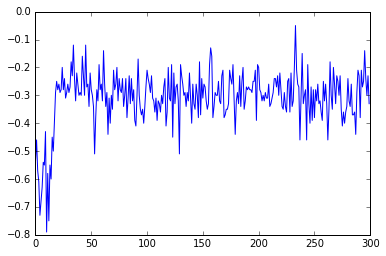

In [14]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [33]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [34]:
sess = tf.InteractiveSession()

In [35]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs/model-2999.cptk


[2017-06-04 14:59:01,865] Restoring parameters from ./dqn_logs/model-2999.cptk


In [36]:
#Reset environment and get the first new observation
s = env.reset()
s = processState(s)
d = False
rAll_t = 0
j_t = 0        

In [13]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

RuntimeError: Attempted to use a closed Session.

In [26]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [31]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 1000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn_logs/model-2999.cptk


[2017-06-04 14:58:20,324] Restoring parameters from ./dqn_logs/model-2999.cptk


500	0.0
954	0.1
1454	0.0
1954	0.0
2454	0.0
2954	0.0
3454	0.0
3954	0.0
4454	0.0
4906	0.1
5406	0.0
5906	0.0
6406	0.0
6857	-0.1
7357	0.0


KeyboardInterrupt: 

In [29]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

NameError: name 'rList_t' is not defined

---------------------------------------------

## Test Random Actor

In [ ]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

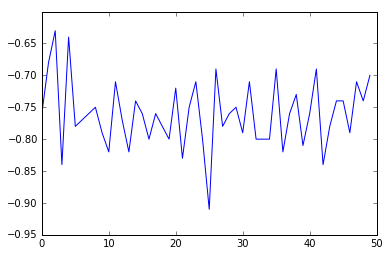

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)